<center><h1> Traffic Simulation
<break>
<center> Michelle Hackl
<center> CS166 - Prof. Sheffler

-----------

### Part 1 - Traffic Jams on a Circular Road
Implement the single lane, variable speed traffic model described in Nagel, K.,
Schreckenberg, M. (1992).
- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show how traffic jams can appear when traffic density is high enough.
- Analyze how the overall average traffic flow rate varies with traffic density and present your results in your report.

### Part 2 - Multi-lane Highways
Implement the 2-lane, symmetric, uni-directional, variable speed model in Rickert, M., et al. (1996).

- A description, in your report, of how this model works. What are the assumptions, parameters, and update rules of the model? Do not just copy and paste from the paper. Explain the cellular automaton in your own words and as clearly as possible.
- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show the typical traffic patterns that can emerge. Your results will again depend on traffic density.
- Analyze how much more traffic can flow through a multi-lane road, compare to a single lane road, at the same traffic density. Present your results in your report.

### Part 3 - General Discussion
- How much more traffic can flow through a 2-lane road compared to a 1-lane road at the same traffic density? What about roads with more than 2 lanes? Either model 3 or more lanes and report on your results, or predict how much larger the traffic flow through a 3+ lane road will be compared to a 1-lane road at the same traffic density.
- How applicable is this model to traffic in your city? Write a short paragraph and motivate why the model is suited to traffic in your city (or why it is not).

In [2]:
#general reference made to this code:
#https://gist.github.com/xmichaelx/2a3b45ba589296da73ef

import numpy as np 
import pylab as pl
import random as rd
import copy

class TrafficSimulation():
    """N-lane traffic simulation based on Rickert et al. (1996)
    and the original Nagel & Schreckenberg (1992) model.
    """
    def __init__(self, len_road = 100, density = 0.01, max_vel = 5, 
                 prob_slowing = 0.5, prob_lane_change = 0.8, lanes = 1):
        self.len_road = len_road
        self.density = density
        self.max_vel = max_vel
        self.prob_slowing = prob_slowing
        self.prob_lane_change = prob_lane_change
        self.lanes = lanes

        self.car_counter = 0
        self.flow_counter = 0
        self.time_counter = 0

        self.config = []
        self.next_config = []


    def initialize(self):
        """
        Sets up the initial state based on density & length and
        initiates the global car count.
        """
        for _ in range(self.lanes):
            self.config.append(pl.zeros([self.len_road], dtype=int))
            self.next_config.append(pl.zeros([self.len_road], dtype=int))

        for lane in self.config:
            lane.fill(-1)
        for lane in self.next_config:
            lane.fill(-1)

        for state in self.config:
            indexes = np.random.choice(range(0, self.len_road),
                      size = int(self.density * self.len_road),
                      replace = False)
            state[indexes] = self.max_vel

        self.car_counter = self.count_cars()


    def lane_change(self):
        """
        Checks for lane changes and moves cars between lanes.
        Rules:
        IF  v > gap
        AND v_o + 1 are empty AND empty behind >= vmax
        AND IF rd.rand < probability of switching
        THEN switch.
        """
        for lane_index, lane in enumerate(self.config):
            for spot in range(self.len_road):
                if lane[spot] != -1:                        #if car
                    switch = False                          #if car will switch lane
                    vel = lane[spot]

                    gap = 0                                 #rule 1 - check ahead            
                    looked_ahead = 0

                    while looked_ahead <= (self.max_vel):
                        if lane[(spot + gap + 1) % self.len_road] < 0:
                            gap += 1
                        else:
                            break
                        looked_ahead += 1

                    if gap < vel:                           #rule 1 - if no space ahead, switch
                        switch = True

                                                            #rule 2 - define neighbors
                    right_neighbor = self.config[(lane_index + 1) % self.lanes]
                    left_neighbor = self.config[(lane_index - 1) % self.lanes]

                    if switch:                              #rule 2 - if planning on switching
                        switch_right = False                
                        switch_left = False
                                                            #rule 2 - check for free lanes
                        if self.neighbor_free(right_neighbor, spot, vel):
                            switch_right = True
                        if self.neighbor_free(left_neighbor, spot, vel):
                            switch_left = True

                                                            #rule 3 - if less than random switching 
                                                            #probability, switch lanes
                        if rd.random() < self.prob_lane_change:
                            self.switch_lanes(lane_index, spot, vel, switch_right, switch_left)
                        else:
                            self.next_config[lane_index][spot] = vel

                                                            #if we're not switching the car, then we
                    else:                                   #have to write it back into it's own lane
                        self.next_config[lane_index][spot] = vel

        # self.state_difference()                                                    
        self.config = copy.deepcopy(self.next_config)        #update config and resetnext_config state
        for lane in self.next_config:                        
            lane.fill(-1)


    def neighbor_free(self, neighbor, cur_spot, vel):
        """
        Takes in a lane, neighboring lane, current spot of the car
        and it's velocity and checks if the neighboring lane has
        enough space for the car. Returns True if so, else False.
        """
        free = True

        gap = 0                    
        check_back = -1 * self.max_vel      #distance to check in the back and front
        check_front = vel

        for index in range(check_back, check_front + 1):
            if neighbor[(cur_spot + index) % self.len_road] < 0:
                pass
            else:
                free = False
                break

        return free


    def switch_lanes(self, lane_index, spot, vel, right, left):
        """
        Determines if cars will be switched to the right or
        left lane and updates the next_config state.
        Because I am updating into the next_config state, some-
        times cars want to switch into the same spot from two sides.
        Here, earlier update cars (left lane) get priority over 
        those from the right lane.
        """
                                                    #checking free slots in the config
                                                    #and the next_config lanes.
        if self.next_config[(lane_index + 1) % self.lanes][spot] == -1:
            right_taken = False
        else: right_taken = True    

        if self.next_config[(lane_index - 1) % self.lanes][spot] == -1:
            left_taken = False
        else: left_taken = True
                                                    #if both lanes free, pick randomly
        if (right and left) and not right_taken and not left_taken:                        
            if rd.random() < 0.5:
                self.next_config[(lane_index + 1) % self.lanes][spot] = vel
            else:
                self.next_config[(lane_index - 1) % self.lanes][spot] = vel
                                                            
        elif right and not right_taken:             #else, pick right or left as free
            self.next_config[(lane_index + 1) % self.lanes][spot] = vel
        elif left and not left_taken:
            self.next_config[(lane_index - 1) % self.lanes][spot] = vel

        else:                                        #if neither, keep car in lane
            self.next_config[lane_index][spot] = vel 


    def update_speed(self):
        """
        Iterates over array and updates all cars' speeds.
        Rules: 
        IF v != vmax      THEN  v+=1
        IF v > gap        THEN  v=gap
        IF V>0 AND rand<p THEN  v-=1
        """
        for lane in self.config:
            for spot in range(self.len_road):
                if lane[spot] != -1:                  #if car
                    vel = lane[spot]

                    if vel < self.max_vel:            #rule 1
                        vel += 1

                    gap = 0                           #rule 2 - count gap size
                    looked_ahead = 0

                    while looked_ahead <= (self.max_vel):
                        if lane[(spot + gap + 1) % self.len_road] < 0:
                            gap += 1
                        else:
                            break
                        looked_ahead += 1


                    if vel > gap:                     #rule 2 - reduce speed to gap
                        vel = max(gap, 0)

                                                      #rule 3 - randomness
                    vel = max(vel - 1, 0) if rd.random() < self.prob_slowing else vel 

                    lane[spot] = vel                  #update speeds


    def move_cars(self):
        """
        Moves cars forward and updates the config states.
        Creates a deep copy of the next_config state and 
        then clears it after moving all cars.
        """
        for lane, next_lane in zip(self.config, self.next_config):
            for spot in range(0, self.len_road):
                if lane[spot] != -1:                 #if car
                    distance = lane[spot]

                    next_lane[int(spot + distance) % self.len_road] = lane[spot]

        self.config = copy.deepcopy(self.next_config)
        for lane in self.next_config:
            lane.fill(-1)


    def count_flow(self):
        """
        Counts the number of cars that will leave the simulation 
        in the following step and updates the time counter.
        """
        for lane in self.config:
            for k in range(-1 * self.max_vel, 0):   #check last max_vel slots
                if lane[k] >= abs(k):               #count if car will move outside lane
                    self.flow_counter += 1

            self.time_counter += 1                  #add one time step


    def count_cars(self):
        """
        Counts the number of cars in the simulation to make
        sure I am not loosing any to a separate dimension 
        along the way...
        """
        car_num = 0
        for lane in self.config:
            car_num += sum([1 if spot != -1 else 0 for spot in lane]) 

        return car_num


    def display(self, message = None):
        """
        Visualizes the self.config states as a string printout.
        """
        if message:
            print(message)              #for debugging

        for lane in self.config:
            string = ''.join(['.' if x == -1 else str(x) for x in lane])
            print(string)


    def state_difference(self):
        """
        Function to aid debugging (shows where changes have)
        ocurred between states. Use before updating next_config.
        """
        state_dif = np.isclose(self.config, self.next_config)
        for lane in state_dif:
            string = ''.join(['.' if x == True else "X" for x in lane])
            print (string)


    def run(self, runs = 10, display = False):
        """ Runs simulation r times. """
        for r in range(runs):
            self.simulate(display = display)


    def simulate(self, display = True):
        """
        Updates the simulation by a single step. Checks for lane changes,
        then updates all car speeds and finally moves cars after
        displaying the state (if display == True).
        """
        self.lane_change()
        self.update_speed()

        if display:                    #show speeds before updating!
            self.display()

        self.count_flow()              #collect metrics before moving cars

        self.move_cars()    

        if self.count_cars() != self.car_counter:
            print("We lost some cars during the run!")


In [ ]:
#-------------------------------------------
# TESTING
#-------------------------------------------

CountryRoad = TrafficSimulation(len_road = 80, density = 0.15, max_vel = 5,
                                prob_slowing = 0.5, prob_lane_change = 0.8, lanes = 1)
CountryRoad.initialize()
CountryRoad.run(5, display=True)


In [137]:
#-------------------------------------------
# PLOTTING FUNCTION
#-------------------------------------------
import sys

def display_flow_graph(len_road = 300, prob_slowing = 0.5, prob_lane_change = 0.8, lanes = [1],
                       runs = 5, densities = np.linspace(0.05, 0.3, 20), col = ['k'], steps = 500,
                       display_runs = True, display_avgline = False, display_CI = False):
    """
    Generates the traffic flow graph as described by Rickert et al. (1996).
    Lanes need to be passed as a list of desired lengths to simulate and plot.
    Colors are passed to match the number of lanes to simulate.
    
    Optional arguments:
    display_runs = plot individual runs as single dots
    display_avgline = average over all runs and plot the resulting line
    display_CI = calculate 95% confidence intervals and display on the graph
    
    The function returns the axis object. This allows for titles or optional
    arguments to be added after running the function without loosing the plot.
    """
    #instantiate plotting
    fig = pl.figure()
    ax = fig.add_subplot(111)
    
    if len(lanes) != len(col):
        print ("Please provide more colors!")
        return
    
    # to track completion of the simulation, counts
    # total number of simulation steps for plotting
    total_runs = (runs * steps * len(densities) * len(lanes)) # +
                  #display_avgline * line_runs * len(densities) * len(lanes))
    finished_runs = 0
    
    for index, lane in enumerate(lanes):

        flow_total = np.zeros((runs, len(densities)))
        flow_total_line = np.zeros((len(densities)))
        
        #running trials and collecting average flow rate over x runs
        for r in range(runs):
            j = 0
            for rho in densities:
                Sim = TrafficSimulation(len_road = len_road, prob_slowing = prob_slowing,
                                        prob_lane_change = prob_lane_change, lanes = lane)
                Sim.density = rho
                Sim.initialize()

                Sim.run(steps)
                finished_runs += steps
                
                #displays completion percentage as an updating single-line print
                sys.stdout.write("\r" + str("Completed: {0:.1f}%".format(float(finished_runs)/total_runs*100)))
                sys.stdout.flush()

                flow_total[r,j] = float(Sim.flow_counter) / float(Sim.time_counter)
                j += 1

        #show individuals points on the plot for each run
        if display_runs:
            for q in range(0, runs):
                ax.scatter(densities, flow_total[q,:], s=6, c=col[index], marker='o', alpha=0.4)
        
        #display averaged line over all runs
        if display_avgline:
            flow_total_line = np.mean(flow_total, axis=0)
            ax.plot(densities, flow_total_line, c=col[index], label="{0:.0f}-lane road".format(lane))
    
        if display_CI:
            #getting descriptive stats to plot confidence intervals
            flow_mean = np.mean(flow_total, axis=0)
            flow_stdev = np.std(flow_total, axis=0)
            flow_upper_bound = [flow_mean[i] + 1.96*flow_stdev[i] for i in range(len(densities))]
            flow_lower_bound = [flow_mean[i] - 1.96*flow_stdev[i] for i in range(len(densities))]
            #plotting CIs
            ax.plot(densities, flow_upper_bound, c=col[index], alpha=0.3)
            ax.plot(densities, flow_lower_bound, c=col[index], alpha=0.3)
        
    ax.legend()
    ax.set_xlabel("Density")
    ax.set_ylabel("Flow")
    
    return ax

---
### Part 1 - Traffic Jams on a Circular Road
** Parameters **

The single-lane model takes the following input parameters: length of the highway, initial density of cars (unchanging since it is a closed-loop system), a maximum velocity at which cars are allowed to travel and a probability of slowing down randomly. This parameter was introduced by Nagel & Schreckenberg (1992) to make the system non-deterministic and more accurately model real world traffic behavior (default 50%). This could represent both overly attentive behavior, when for example a driver breaks before the car in front of her slows down, or careless behavior, where a driver paying little attention to the road does not keep a constant speed or takes a few seconds to speed up after moving out of a traffic jam.

** The Model **

The below display shows traffic jams building on the single-lane, circular model when density is high. Below I analyze traffic flow of this model, which peaks at around 0.35 cars per update step (second) when density is at 0.08. Note that the standard deviation is highest around the infliction point of a density of 0.08.

In [123]:
#-------------------------------------------
# PART 1 - SINGLE LANE ROAD
#-------------------------------------------

# Show traffic jams at high density
Highway = TrafficSimulation(len_road = 70, density = 0.3, max_vel = 5,
                            prob_slowing = 0.5, prob_lane_change = 0.8, lanes = 1)
Highway.initialize()
Highway.run(35, display=True)

....5........0.02...4......1.04....1.0.04........3...0.0.1..02..02...3
..4......2...0.0..2.....3...00....1.01.0....4.......00.0..1.0..00..3..
4.....4....1.1.1....3......000.....01.00........3...00.1...01..00.....
....4.....1.0.0.2......2...000.....1.001...........001..1..1.1.00.....
........1..00.0...3......0.001......001.1..........01.2..1..1.000.....
.........1.01.1......2...1.01.1.....00.1.2.........0.2..0.2..0000.....
..........01.1.2.......2..01.0.1....01..1..3.......1...00...00001.....
..........0.0.1..2.......00.01..1...1.1..2....4.....2..00...0000.1....
..........1.0..2...2.....01.0.1..1...0.2...2......3...000...0001..2...
...........01....3...2...0.01..1..1..1...2...3.......0001...000.2...3.
.3.........0.1......2..0.1.0.2..2..2..2....3....3....001.2..001...2...
....3......1..2.......01..00...2..1..2..2.....4....0.01.1..001.1....2.
3......4....1...3.....1.1.00.....0.2...2..3.......00.1.0.1.01.1.1.....
...3.......0.1.....2...0.001.....0...3...3...3....00..01..01.0.0.1....
......

Completed: 100.0%

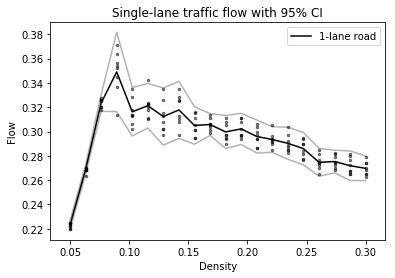

In [144]:
# Plot the density of the simulation
plot = display_flow_graph(runs = 8, steps = 800, display_runs = True, display_avgline = True, display_CI = True)
pl.title("Single-lane traffic flow with 95% CI")
pl.show()

### Part 2 - Multi-lane Highways
**Description and update rules**

The above code can be expanded to an n-lane, circular highway that wraps around on either side (essentially a taurus), by passing in a lane argument. While this seems unrepresentative of the real world a first, it could represent cars leaving and joining the highway in a real world scenario. In addition to the standard movement and speed update rules:
- IF velocity != maximum speed THEN insrease velocity by 1
- IF velocity > than the gap in front THEN  velocity equals the gap 
- IF velocity > 0 AND probability of randomly slowing down is met THEN reduce velocity by 1
        
cars on the 2-lane road first check if they are going to have to slow down on the next step. If there is a car in front of them, they attempt to change lanes based on the following rules:
- IF  velocity of car > gap in front of it
- AND there is max_vel space behind and velocity + 1 space in front on the neighboring lane (I have combined these two rules into a single sweep, since either condition not being met would prevent lane switching regardless of the other)
- AND IF the probability of switching is met,
- THEN the car will switch lanes.

In addition to these basic rules, on the n-lane model cars can switch either left or right. In the code above, I check availability on both lanes if switching is initiated and if both are free, a lane is chosen at random. This creates symmetric switching conditions. Due to the order of updates in the array, the switch_lanes function gives priority to cars switching right over those switching left in *extreme corner cases (this happens so rarely, the error only showed up on one out of ~50 runs)* where two cars from different lanes happen to try to switch into the exact same spot. After switching, cars are updated and moved just like in the single-lane model.

The density-flow plot below shows that with an additional lane, we can increase traffic flow up to 0.375, being able to move slighly more than twice the cars (since density is now a function of the average over 2 lanes), than we would with just a single lane. This suggests that the lane change model actually allows for smoother traffic flow than two single lanes would, side by side. The curve also declines more slowly with increased density, showing that the average movement speed of cars stays higher on a 2-lane compared to a 1-lane highway, and traffic jams form less and resolve faster by allowing lane changes.

**Parameters**

The multi-lane model consists of the same parameters as described above for the single-lane model, with the addition of a lane change probability (default 80%).  If cars switch lanes with 100% probability when space is free, this leads to tail-gating behavior that can be broken if cars sometimes do not switch. This reflects real world behavior since cars there do not always switch lanes when possible or when seeing that the car in front of them is already indicating that they plan a lane change (a time step that our simulation cannot represent, but can be approximated with the lange change probability parameter).

Completed: 100.0%

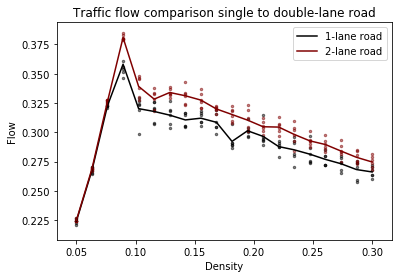

In [145]:
#-------------------------------------------
# QUESTION 2 - TWO-LANE
#-------------------------------------------

# Show behavior of 2-lane system
plot2 = display_flow_graph(runs = 6, steps = 900, lanes = [1,2], col = ['k', 'maroon'],
                           display_runs = True, display_avgline = True, display_CI = False)
pl.title("Traffic flow comparison single to double-lane road")
pl.show()

### Part 3 - General Discussion

**Multi-lane comparison**

The below plot shows that there is sidnificant increase in traffic flow when increasing the number of lanes from one to two and allowing cars to move around traffic jams. It also demonstrates, however, that further increase in lanes does not significantly increase the traffic flow at critical density. The only marginal advantage that a n-lane (in our graph 10-lane) highway has over the standard 2-lane road is that it maintains slightly higher flow rates as density increases. In a real world scenario, where we would expect traffic to be added to the highway only from one side (all cars have to enter and leave on the right side), we might actually expect a 10-lane model to perform significantly worse on average traffic flow, since there would be a higher density in the first few lanes that leads to excessive traffic jams. The world's largest highway supports an impressive 11 lanes, but solves the traffic jam problem by combining from smaller roads and splitting into smaller roads before allowing cars to move off. The middle piece of this highway could actually be modelled fairly accurately by my simulation.

** Traffic in Buenos Aires** 

Given the many small roads and grid-like structure of Buenos Aires traffic, the traffic model could only accurately reflect traffic in the 1-lane model. As such, it is moderately well-suited to model traffic, but could be greatly improved by random obstacles (eg. taxi drivers stopping, people crossing the road away from pedestrian walks, angry protesters, potholes causing cars to slow down, etc.). 

**Good Driver Behavior**

In part 3.2 I am modelling "good driver behavior" by reducing the probability of randomly slowing down from 50% to 10%. This could reflect extremely attentive driving or drivers using their cruise control on the highway, preventing them from slowing down randomly (I personally drive this way on the highway and find it to make for a very smooth driving experience). As the plot shows, this good driver behavior significantly increases the average traffic flow by a factor of two, and the decrease as density increases is minimized. It also reduces the difference between single, two, and ten-lane highways to a minimum, suggesting that if people do not slow down randomly, we could grealt increase the traffic flow of our streets regardless of size and traffic jams would occur less frequently/be resolved faster.

Completed: 100.0%

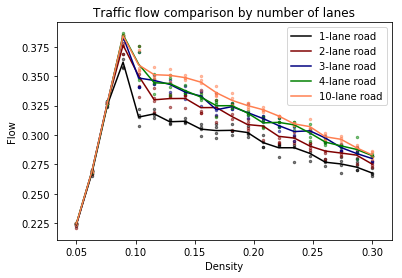

In [146]:
#-------------------------------------------
# QUESTION 3.1 - N-LANE
#-------------------------------------------

# Assuming "good" driver behavior where drivers barely 
# ever slow down randomly
plot3 = display_flow_graph(lanes = [1,2,3,4,10], runs = 4, steps = 1200, col = ['k', 'maroon', 'navy', 'g', 'coral'],
                           display_runs = True, display_avgline = True, display_CI = False)
pl.title("Traffic flow comparison by number of lanes")
pl.show()

Completed: 100.0%

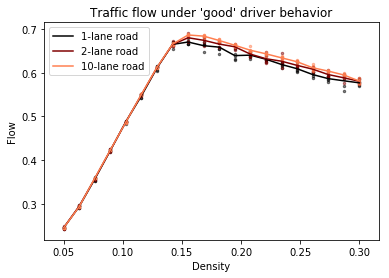

In [149]:
#-------------------------------------------
# QUESTION 3.2 - GOOD DRIVER BEHAVIOR
#-------------------------------------------

# Assuming "good" driver behavior where drivers barely 
# ever slow down randomly (eg. cruise control)
plot4 = display_flow_graph(prob_slowing = 0.1, prob_lane_change = 0.8, runs = 5, steps = 600,
                           lanes = [1, 2, 10], col = ['k', 'maroon', 'coral'],
                           display_runs = True, display_avgline = True, display_CI = False)
pl.title("Traffic flow under 'good' driver behavior")
pl.show()

### Future Work
On top of the extensions already suggested in class or by the original work of Rickert, M., et al. (1996), I would suggest that little modifications are needed to accurately model traffic flow on any high-way like system. The chosen parameters have proven up to the task of being compared against real world rods. Section 3.2, however, suggests that small modifications to driver behavior (eg. more active use of cruise control) could greatly increase higway efficiency. This hypothesis could be tested on a test track and, if it proves robust, taken onto real world highways by, for example, reminding people to use cruise control (the effectiveness of such reminders is topic of different research). This simple modification suggests that self-driving cars might not be the only modification able to improve our driving behavior significantly (at least with regards to highways).